# LAB 5: Text classification with Naive Bayes

Objectives:

* Train and evaluate Naive Bayes text classifiers
* Cross-validation
* Hyperparameter search

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

### Load and preprocess data

In [2]:
df = pd.read_parquet(
    "s3://ling583/rcv1-politics.parquet", storage_options={"anon": True}
)

In [3]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [4]:
def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [5]:
df["tokens"] = df["text"].progress_apply(tokenize)

  0%|          | 0/60509 [00:00<?, ?it/s]

Baseline Dummy Classifier 

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

In [8]:
baseline = DummyClassifier()
cross_val_score(baseline, df["tokens"], df["pol"], cv=cv)

array([0.92951578, 0.92951578, 0.92951578, 0.92943315, 0.92950996])

----

### Multinomial Naive Bayes

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

Set up a pipeline: first convert tokenized text into feature vectors, then apply naive Bayes classifier

In [10]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

In [11]:
predicted = cross_val_predict(mnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.99      0.90      0.95     56243
        True       0.41      0.92      0.57      4266

    accuracy                           0.90     60509
   macro avg       0.70      0.91      0.76     60509
weighted avg       0.95      0.90      0.92     60509



---

### Hyperparameter search

In [12]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46039")
client

Client Scheduler: tcp://127.0.0.1:46039 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.67 GB


In [13]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [14]:
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

In [15]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

In [16]:
%%time

search = RandomizedSearchCV(
    mnb, {"multinomialnb__alpha": loguniform(1e-10, 10.0)}, n_iter=25, scoring="f1"
)
search.fit(df["tokens"], df["pol"])

CPU times: user 16.2 s, sys: 2.07 s, total: 18.2 s
Wall time: 1min 49s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f312cf212b0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30606f47c0>},
                   scoring='f1')

In [17]:
search.best_params_

{'multinomialnb__alpha': 3.117427914619232e-08}

In [18]:
search.best_score_

0.6446072758472924

In [19]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

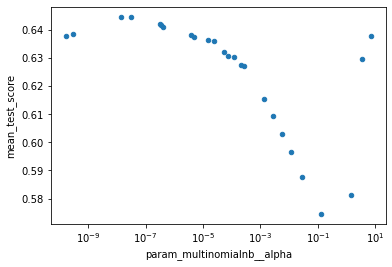

In [20]:
cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

In [21]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 5),
        "multinomialnb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 16.2 s, sys: 1.88 s, total: 18 s
Wall time: 2min 3s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f312cf212b0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3048d72250>,
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3048d905e0>},
                   scoring='f1')

In [22]:
search.best_params_, search.best_score_

({'countvectorizer__min_df': 1,
  'multinomialnb__alpha': 1.5982475335782055e-08},
 0.6453322654176297)

In [23]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

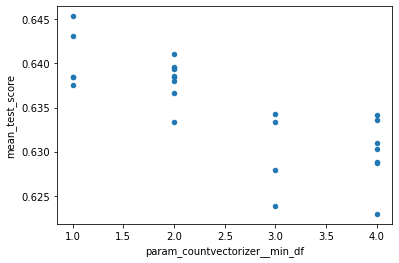

In [24]:
cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

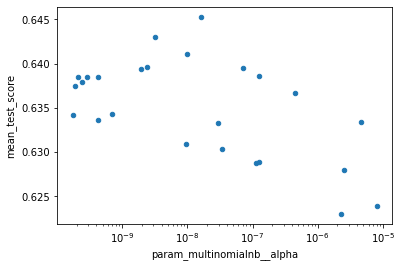

In [25]:
cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

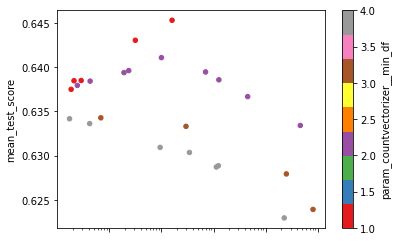

In [26]:
cv_results.plot(
    "param_multinomialnb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

In [27]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": [1],
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 16.4 s, sys: 2 s, total: 18.4 s
Wall time: 3min 56s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f312cf212b0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3048d3f8e0>,
                                        'countvectorizer__min_df': [1],
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3067054e20>},
                   scoring='f1')

In [28]:
search.best_params_, search.best_score_

({'countvectorizer__max_df': 0.8098880133739912,
  'countvectorizer__min_df': 1,
  'multinomialnb__alpha': 1.4682077504151795e-08},
 0.6453942136509543)

<AxesSubplot:xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

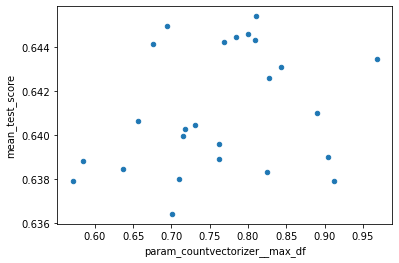

In [29]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

---

### Evaluate final model

In [30]:
mnb.set_params(multinomialnb__alpha=1e-10, countvectorizer__min_df=1, countvectorizer__max_df=0.8635016859255573)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x7f312cf212b0>,
                                 max_df=0.8635016859255573)),
                ('multinomialnb', MultinomialNB(alpha=1e-10))])

In [31]:
predicted = cross_val_predict(mnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.98      0.95      0.97     56243
        True       0.56      0.76      0.64      4266

    accuracy                           0.94     60509
   macro avg       0.77      0.86      0.80     60509
weighted avg       0.95      0.94      0.94     60509



The best performing f1 score for the multinomial naive bayes model is at 0.64, compared to bernoulli's f1 score of 0.60. We can see that 56% of documents are flagged as politics really are about politics and 76% of those documents are getting flagged. So it would seem that the multinomial modeling is preferred over bernoulli.